In [194]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

In [195]:
SF_CRIME_VISUAL = """
        SELECT
            COUNT( DISTINCT unique_key) as count,
            cast(EXTRACT(YEAR FROM SFCrimeData.timestamp)*100 +
            EXTRACT(MONTH FROM SFCrimeData.timestamp) as string) as date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE category != "NON-CRIMINAL" AND category != "RECOVERED VEHICLE" 
        GROUP BY date
        ORDER BY date ASC
        """
bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_VISUAL)

In [196]:
df_SF_census = pd.read_csv('../../data/censuspopulationsf.tsv', sep='\t', header=None)
df_SF_census.columns = ['year', 'pop']
# make column for counts per capita
util.per_capita(df_SF_crime, df_SF_census)

In [197]:
df_SF_crime['formatted_date'] = pd.to_datetime(df_SF_crime['date'], format='%Y%m')
df_SF_crime['per_capita'] *=100000
df_SF_crime.head()

,count,date,per_capita,formatted_date
0,9464,200301,1249.145370,2003-01-01
1,8671,200302,1144.477970,2003-02-01
2,9398,200303,1240.434086,2003-03-01
3,9154,200304,1208.228732,2003-04-01
4,9127,200305,1204.665025,2003-05-01


Text(0.5,1,'Crime per-capita between 2003 & 2018')

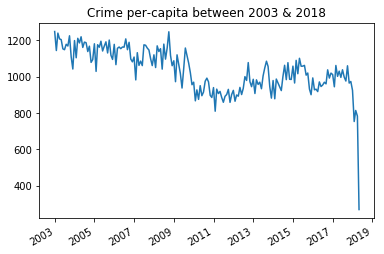

In [198]:
# plot original data (this is monthly increments)
fig, ax = plt.subplots()
ax.plot(df_SF_crime['formatted_date'], df_SF_crime['per_capita'])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Crime per-capita between 2003 & 2018')

In [199]:
# build a model for 2003 - 2009 (to match the range in our pollution data)
SF_CRIME_QUERY = """
        SELECT
            COUNT( DISTINCT unique_key) as count,
            cast(EXTRACT(YEAR FROM SFCrimeData.timestamp)*10000 +
            EXTRACT(MONTH FROM SFCrimeData.timestamp)*100 + 
            EXTRACT(DAY FROM SFCrimeData.timestamp) as string) as date
        FROM
          `bigquery-public-data.san_francisco_sfpd_incidents.sfpd_incidents` AS SFCrimeData
        WHERE EXTRACT(YEAR FROM  SFCrimeData.timestamp) < 2010  AND category != "NON-CRIMINAL" AND category != "RECOVERED VEHICLE"
        GROUP BY date
        ORDER BY date DESC
        """
bq_assistant_SF_crime = BigQueryHelper("bigquery-public-data", "san_francisco_sfpd_incidents.sfpd_incidents")
df_SF_crime = bq_assistant_SF_crime.query_to_pandas(SF_CRIME_QUERY)

In [200]:
# add counts per capita column
util.per_capita(df_SF_crime, df_SF_census)
df_SF_crime['per_capita'] *=100000

In [201]:
df_SF_crime.head()

,count,date,per_capita
0,235,20091231,30.348151
1,260,20091230,33.576678
2,235,20091229,30.348151
3,210,20091228,27.119625
4,238,20091227,30.735575


In [202]:
# find optimum regressor
regr = rfr.find_regressor(df_SF_crime['date'].as_matrix().reshape(-1,1), df_SF_crime['per_capita'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.7s
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.7s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   0.8s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   0.9s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [203]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_SF_crime['date'].to_frame(), df_SF_crime['per_capita'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [204]:
cv.MSE(y_test, y_pred)

18.137623997120688

In [205]:
tss_score = cv.Cross_Validation(df_SF_crime['date'].to_frame(), df_SF_crime['per_capita'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 28.610080558389036 


Text(0.5,1,'Predicted crime per capita')

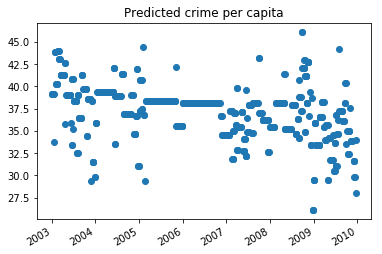

In [206]:
X_test['formatted_date'] = pd.to_datetime(X_test['date'], format='%Y%m%d')
# plot original data 
fig, ax = plt.subplots()
ax.plot(X_test['formatted_date'], y_pred, 'o')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Predicted crime per capita')

Text(0.5,1,'Residual plot')

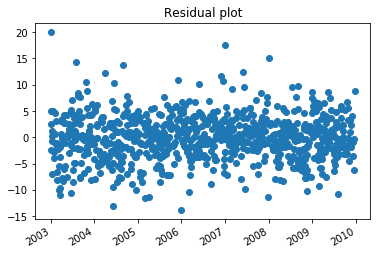

In [207]:
residuals = y_test - y_pred
fig, ax = plt.subplots()
ax.plot(X_test['formatted_date'], residuals, 'o')
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 10
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('Residual plot')